<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span></li></ul></div>

# Load the data
First, load the data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing

#Load data
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls',
                   header=4)

#Make subtable copy of the original data with only the features we want.
df1 = df[['City', 'Population']].copy()
df1['population_sq'] = df['Population'] * df['Population']
df1['murder_yn'] = np.where(df['Murder and\nnonnegligent\nmanslaughter'] == 0, 0, 1)
df1['robbery_yn'] = np.where(df['Robbery'] == 0, 0, 1)
print(df1.head())

                       City  Population  population_sq  murder_yn  robbery_yn
0             Adams Village      1861.0   3.463321e+06          0           0
1  Addison Town and Village      2577.0   6.640929e+06          0           0
2             Akron Village      2846.0   8.099716e+06          0           0
3                    Albany     97956.0   9.595378e+09          1           1
4            Albion Village      6388.0   4.080654e+07          0           1


# Data Cleaning


In [3]:
#Check how many null values we have for each column
df1.isnull().sum()

#Drop missing values.
df1 = df1.dropna()

We can also check the distribution of the data.

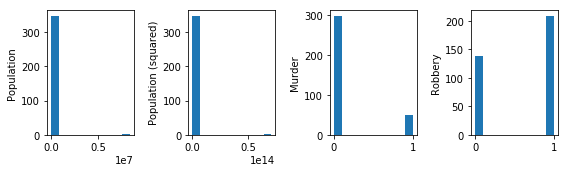

In [4]:
#Check the distribution of the variables
plt.figure(figsize = (8, 2.5))
plt.subplot(141)
plt.hist(df1['Population'])
plt.ylabel('Population')
plt.subplot(142)
plt.hist(df1['population_sq'])
plt.ylabel('Population (squared)')
plt.subplot(143)
plt.hist(df1['murder_yn'])
plt.ylabel('Murder')
plt.subplot(144)
plt.hist(df1['robbery_yn'])
plt.ylabel('Robbery')
plt.tight_layout()
plt.show()

It looks like we have some extreme values in population, which also affects the squared population. Let's winsorize the data.

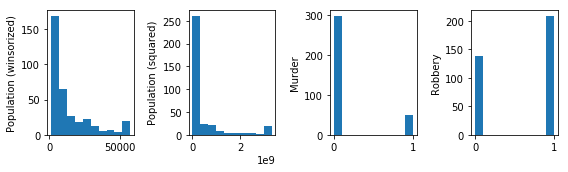

In [7]:
#Dealing with extreme values --- winsorizing
df1['population_win'] = stats.mstats.winsorize(df1['Population'], limits=[0.05, 0.05])
df1['population_sq_win'] = df1['population_win'] * df1['population_win']

#Check the distribution of the variables again
plt.figure(figsize = (8, 2.5))
plt.subplot(141)
plt.hist(df1['population_win'])
plt.ylabel('Population (winsorized)')
plt.subplot(142)
plt.hist(df1['population_sq_win'])
plt.ylabel('Population (squared)')
plt.subplot(143)
plt.hist(df1['murder_yn'])
plt.ylabel('Murder')
plt.subplot(144)
plt.hist(df1['robbery_yn'])
plt.ylabel('Robbery')
plt.tight_layout()
plt.show()

Slightly better. But the population is still not normal distributed. Log transformation may help.

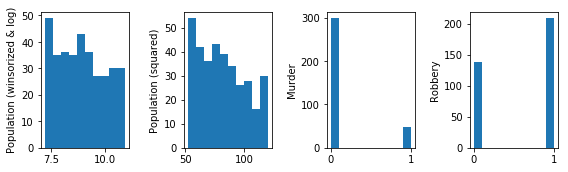

In [8]:
#Dealing with non-normality --- log transformation
df1['population_log'] = np.log(df1['population_win'])
df1['population_sq_log'] = df1['population_log'] * df1['population_log']

#Check the distribution of the variables again
plt.figure(figsize = (8, 2.5))
plt.subplot(141)
plt.hist(df1['population_log'])
plt.ylabel('Population (winsorized & log)')
plt.subplot(142)
plt.hist(df1['population_sq_log'])
plt.ylabel('Population (squared)')
plt.subplot(143)
plt.hist(df1['murder_yn'])
plt.ylabel('Murder')
plt.subplot(144)
plt.hist(df1['robbery_yn'])
plt.ylabel('Robbery')
plt.tight_layout()
plt.show()

Still not great. But we are going to go with it.

Now we can preprocess the categorical variables for modeling, using OneHotEncoder.

In [9]:
#OneHotEncoder to prepare the categorical variables for linear regression
enc = preprocessing.OneHotEncoder()
enc.fit(df1[['murder_yn', 'robbery_yn']])
onehotlabels = enc.transform(df1[['murder_yn', 'robbery_yn']]).toarray()

#Finalize the dataframe for modeling
df_ready = df1[['population_log', 'population_sq_log']]
a = pd.DataFrame(onehotlabels)
df_ready = pd.concat([df_ready, a], axis=1)
print(df_ready.head())

   population_log  population_sq_log    0    1    2    3
0        7.528869          56.683872  1.0  0.0  1.0  0.0
1        7.854381          61.691304  1.0  0.0  1.0  0.0
2        7.953670          63.260863  1.0  0.0  1.0  0.0
3       10.960566         120.134002  0.0  1.0  0.0  1.0
4        8.762177          76.775737  1.0  0.0  0.0  1.0
